# HR monitor during physical exercise 
Implement of these paper:
</br>
Denosing using wiener filter:
[Accurate Heart Rate Monitoring During Physical Exercises Using PPG
](https://ieeexplore.ieee.org/abstract/document/8571310)
</br>
Measure HR more accurate:
[Finite State Machine Framework with Crest Factor and HR Change](https://ieeexplore.ieee.org/document/8468028)


## import library

In [309]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
from scipy.interpolate import interp1d
from statistics import mean, stdev,median
import re
import pandas as pd
import math

plt.style.use('ggplot')

sys.path.insert(0, os.path.abspath('lib'))
import file_read
import sig_proc as sp

    
def plot_acc(accX, accY, accZ):
    plt.figure(figsize=(10,9))
    plt.subplot(311)
    plt.title('acc X', fontsize=16)
    plt.plot(accX)
    plt.subplot(312)
    plt.title('acc Y', fontsize=16)
    plt.plot(accY)
    plt.subplot(313)
    plt.title('acc Z', fontsize=16)
    plt.plot(accZ)
    plt.show()
def check_var(a_variable):
    is_global = a_variable in globals()
    return is_global

def RMS_amp(data):
    squaredData = []
    for val in data:
        squaredData.append(val**2)
    
    ms = np.mean(squaredData)
    rms = math.sqrt(ms)
    return rms

def downsample(data, nth):
    newdata = []
    for i in range(0, len(data), nth):
        newdata.append(data[i])
    return newdata
    
class freqAnaysis:
    def __init__(self, sr, sig):
        self.freqs = []
        self.psd = []
        self.max_psd_freq = 0
        self.sr = sr
        self.sig = np.array(sig)
        
        self.fig_size = (10,3)
        self.font_size = 16
    def periodogram(self):
        self.freqs, self.psd = signal.periodogram(self.sig, self.sr)
        self.max_psd_freq = np.round(self.freqs[np.argmax(self.psd)],4)
        return self.freqs, self.max_psd_freq
        
    def fft(self,n_fft=1024):
        self.psd = np.abs(np.fft.rfft(self.sig, n_fft))

        time_step = 1 / self.sr
        # Only process real part of fft 
        self.freqs = np.fft.rfftfreq(n_fft, time_step)
        self.max_psd_freq = np.round(self.freqs[np.argmax(self.psd)],4)
        if self.max_psd_freq == 0:
            self.max_psd_freq = np.round(self.freqs[np.argmax(self.psd)],4)
        return self.freqs, self.psd
       
    def plot_psd(self, titleName = "PSD", ):
        if self.freqs != [] and self.psd !=[]:
            plt.figure(figsize=self.fig_size)
            plt.title(titleName, fontsize=16)
            plt.semilogx(self.freqs, self.psd)
            plt.axvline(self.max_psd_freq, label='Major PSD', color='blue', ls='--')

            textY = max(self.psd)*0.7
            textX = self.max_psd_freq*1.1
            plt.text(textX, textY, 'Dominant PSD: ' + str(self.max_psd_freq) + 'Hz',c = 'blue', fontsize=self.font_size)
        else: 
            raise ValueError("Call fft method before this!")
        #return self.freqs, self.max_psd_freq



In [310]:
# initialize parameters

## sampling
start_sec = 1
period = 6
num_window = 90
overlap = 4
hop_length = period - overlap
'''''''''''''''''''''''''''''''''''''''
Signal quality index
'''''''''''''''''''''''''''''''''''''''
SNR_HR_thresh = 0.8

'''''''''''''''''''''''''''''''''''''''
threshold
'''''''''''''''''''''''''''''''''''''''
# tm_init_cc_thr = 0.8
tm_init_cc_thr = 0.5

# Threshold of two ppg waveform correlation coefficient 
cc_thr = 0.5
# Number of pulse in one window should greater than this, else would be dump
# Lower down this param to get roughly estimate
num_tm_thr = 2

# Overall parameters
WFlength = 15 # Wiener filter length, user tunable param
n_fft = 1024

'''''''''''''''''''''''''''''''''''''''
figure configuration
'''''''''''''''''''''''''''''''''''''''
title_font_size = 16
font_size = 14
fig_size  = (12,3)
marker_size = 6

if num_window > 20:
    plot_flag = False
else:
    plot_flag = True


## Main

In [311]:

folder = '../data/dynamicHR_newFM'
subFolder = 'nicole'
fileName = subFolder + '_stair.csv'
# fileName = 'sit_and_stand.txt'

sr = 50

#------------------------------------------------------------
# Load file
filePath = os.path.join(folder, subFolder, fileName)
dataDict = file_read.loadData(filePath)


G2_y = dataDict['G']
accX = dataDict['accX']
accY = dataDict['accY']
accZ = dataDict['accZ']
acc_scalar = dataDict['acc']

''' Select the duration of PPG segment in seconds'''
if not check_var("start_sec"):
    start_sec = 0
if not check_var("period"):
    period = 10
if not check_var("num_watching_period"):
    num_watching_period = 10

overlap = 4
data_length = len(G2_y)/sr
hop_length = period - overlap
# num_watching_period = int((data_length - overlap)/hop_length) -1


# initial list
filtered_PPG =np.zeros((num_window, int(period*sr)))
W1_FFTi = np.zeros((num_window, int(n_fft/2)+1)) 
W2_FFTi = np.zeros((num_window, int(n_fft/2)+1)) 
PPG_FFT = np.zeros((num_window, int(n_fft/2)+1)) 
PPG_FFT_FIN = np.zeros((num_window, int(n_fft/2)+1)) 
HR_est_list = np.zeros(num_window)
HR_track_list = np.zeros(num_window)
HR_valid_list = np.zeros(num_window)
crest_factor = np.zeros(num_window)
state = np.zeros(num_window)

''' Vital sign dictionary initialize'''
mean_feat_list = {
    'subFolder': [],
    't': [],
    't1':[],
    't2':[],
    't2/t': [],
    't1/t':[],
    '1/t':[],
    'HR': [],
}


# FSM parameters 
HR_change_2s = 5
HR_change_4s = 9
HR_change_6s = 12.8
CF_thr = 6
cn_alert = 0
cn_uncertain = 0
cn_recovery = 0
# Transition times of each state
N_alert = 5
N_uncertain= 3
N_recovery = 4

for n in range(num_window):
    
    # if n > 10:
    #     plot_flag = True
    # else:
    #     plot_flag = False
    
    t1 = np.round(start_sec +  (period-overlap) * n, 2)
    t2 = np.round((t1 + period),2)
    s1 = int(t1*sr)
    s2 = int(t2*sr )
    
    acc_s1 = int(t1*sr)
    acc_s2 = int(t2*sr )


    # initialize template
    tm_initial_flag = False
    tm_count=0
    tm_set = []

    # Storing single pulse and its location
    fix_pulse_set = []
    pulse_loc_set = [] # store two valley and peak location 

    feat_per_beat = {
        'peak':[],
        'valley':[],
        't': [],
        't1': [],
        't2': [],
        't2/t': [],
        't1/t':[],
        '1/t':[]
    }

    excellent_feat_per_beat = {
        'peak':[],
        'valley':[],
        't': [],
        't1': [],
        't2': [],
        't2/t': [],
        't1/t':[],
        '1/t':[]
    }
    excellent_beat_cnt = 0

    #------------------------------------------------------------
    # Signal Preprocessing
    # G2 preprocess
    filtered_G2 = sp.ppg_preprocess(G2_y[s1:s2], sr, norm=1)
    G2_sample_list = np.arange(len(filtered_G2))
    filtered_PPG[n] = filtered_G2
    # filtered_G2 = np.array(filtered_G2) - min(filtered_G2)
    
    
    filtered_accX = sp.butter_bandpass_filter(accX[s1:s2], 0.5, 5, sr, 4)
    filtered_accY = sp.butter_bandpass_filter(accY[s1:s2], 0.5, 5, sr, 4)
    filtered_accZ = sp.butter_bandpass_filter(accZ[s1:s2], 0.5, 5, sr, 4)

    ''' SNR Calculation'''
    h_b, h_a = sp.hp_filter(0.5, sr, 4)
    hp_G2 = signal.filtfilt(h_b, h_a, sp.flip_up_down(G2_y[s1:s2])) 
    SNR_G2 = sp.snr_calc(filtered_G2, hp_G2)

    G2_peak_loc,G2_peak_time, G2_valley_loc, G2_valley_time, adap_win_size = sp.find_peak_valley(sr, filtered_G2, G2_sample_list)
    # R_peak_loc,R_peak_time, R_valley_loc, R_valley_time, adap_win_size = sp.find_peak_valley(sr, filtered_R, R_sample_list)

    pulse_loc_set = sp.pulse_seg(G2_peak_loc, G2_valley_loc)
    # pulse_loc_set.extend(pulse_loc) # alllocation of pulse
    num_pulse = len(pulse_loc_set) # number of pulse in short segment

    #------------------------------------------------------------
    # Extract each pulse segment and its feature
    for j in range(num_pulse):
        valley1_loc = pulse_loc_set[j][0]
        valley2_loc = pulse_loc_set[j][2]
        peak_loc = pulse_loc_set[j][1]

        _v_amp = (filtered_G2[valley1_loc] + filtered_G2[valley2_loc])/2
        t = valley2_loc-valley1_loc
        feat_per_beat['peak'].append(filtered_G2[peak_loc])
        feat_per_beat['valley'].append(_v_amp)
        feat_per_beat['t'].append(t)
        feat_per_beat['t1'].append((peak_loc-valley1_loc)/sr)
        feat_per_beat['t2'].append((valley2_loc-peak_loc)/sr)
        feat_per_beat['t2/t'].append((valley2_loc-peak_loc)/t)
        feat_per_beat['t1/t'].append((peak_loc-valley1_loc)/t)
        feat_per_beat['1/t'].append(1/(t/sr))

    template_length = int(median(feat_per_beat.get('t')))
    if template_length > sr*1.25:
        template_length = sr*1.25

    #------------------------------------------------------------
    # Template initial
    for i in range(num_pulse):
        single_filtered_ppg = sp.single_pulse_tailor(pulse_loc_set[i], filtered_G2, template_length)
        fix_pulse_set.append(single_filtered_ppg)

        if i ==0:
            ref_pulse = single_filtered_ppg
        elif i > 0:
            test_pulse = single_filtered_ppg
            cc = sp.corrcoef(test_pulse, ref_pulse)
            ref_pulse = test_pulse
            '''''''''''''''''''''''''''''''''''
            Create template
            '''''''''''''''''''''''''''''''''''
            if cc > cc_thr:
                tm_set.append(test_pulse)

    if tm_set != []:
        if len(tm_set) > num_tm_thr:
            tm_initial_flag = True
            avg_template = np.mean(tm_set, axis=0)

    #------------------------------------------------------------
    # plot figure
    if plot_flag:
        fig = plt.figure(figsize = (21 ,4))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)
        ax1.plot(G2_sample_list, filtered_G2)
        fig_name = 'PPG'+", "+ subFolder+ ", time: " +str(n) + "," + str(t1) + ":" + str(t2)
        ax1.set_title(fig_name)
        
        
        
        ax2.plot(filtered_accX, label="X")
        ax2.plot(filtered_accY, label="Y")
        ax2.plot(filtered_accZ, label="Z")
        ax2.set_title("ACC")
        ax2.set_ylim([-1,1])
        ax2.legend()
        

    # Plot peak and valley
    if G2_peak_loc != []:
        if tm_initial_flag:
            for i in range(num_pulse):
                loc = pulse_loc_set[i][1]
                fix_pulse = fix_pulse_set[i]
                corr_socre = sp.corrcoef(avg_template, fix_pulse)
                if corr_socre < cc_thr and plot_flag:
                    ax1.plot(loc, filtered_G2[loc], 'v', c='red', ms=marker_size)
                    ax1.text(loc, filtered_G2[loc],  str(i))

                else:
                    if plot_flag:
                        ax1.plot(loc, filtered_G2[loc], 'v', c='Navy', ms=marker_size)
                        # ax1.text(loc, filtered_G2[loc], str(i))

                    '''''''''''''''''''''''''''''''''''''''
                    Excellent beat choosen by TM
                    '''''''''''''''''''''''''''''''''''''''
                    excellent_beat_cnt +=1
                    excellent_feat_per_beat['peak'].append(feat_per_beat['peak'][i])
                    excellent_feat_per_beat['valley'].append(feat_per_beat['valley'][i])
                    excellent_feat_per_beat['t'].append(feat_per_beat['t'][i])
                    excellent_feat_per_beat['t1'].append(feat_per_beat['t1'][i])
                    excellent_feat_per_beat['t2'].append(feat_per_beat['t2'][i])
                    excellent_feat_per_beat['t2/t'].append(feat_per_beat['t2/t'][i])
                    excellent_feat_per_beat['t1/t'].append(feat_per_beat['t1/t'][i])
                    excellent_feat_per_beat['1/t'].append(feat_per_beat['1/t'][i])

    
    if excellent_beat_cnt >1:
        mean_hb = mean(excellent_feat_per_beat['1/t'])
        heart_beat = np.round(mean_hb,2)
    else:
        heart_beat = 0
        
    #------------------------------------------------------------
    # Spectra Analylize
    
    # downsample to 25Hz
    filtered_G2 = downsample(filtered_G2, 2)
    filtered_accX = downsample(filtered_accX, 2)
    filtered_accY = downsample(filtered_accY, 2)
    filtered_accZ = downsample(filtered_accZ, 2)
    down_sr = 25 # new sample rate
    
    # Observed power spectrum
    PPG_FFT[n] = np.abs(np.fft.rfft(filtered_G2, n_fft)) # Only process real part of fft 
    freqs = np.fft.rfftfreq(n_fft, 1/down_sr)
    
    ACC_X_FFT = np.abs(np.fft.rfft(filtered_accX, n_fft))
    ACC_Y_FFT = np.abs(np.fft.rfft(filtered_accY, n_fft))
    ACC_Z_FFT = np.abs(np.fft.rfft(filtered_accZ, n_fft))

    #-------------------------------------------------------
    # Apply wiener filter
    WC1 = WFlength
    WC2 = WFlength
    
    # Wiener 1 
    W1_FFTi[n] = abs(PPG_FFT[n])/max(abs(PPG_FFT[n]))
    if n == 0:
        W1_PPG_FFT_ALL = W1_FFTi[n]
    else:
        W1_PPG_FFT_ALL = np.mean(W1_FFTi[max(0,n-WC1):n],0)
    W1_PPG_FFT_ALL_norm = np.array((W1_PPG_FFT_ALL)/max(W1_PPG_FFT_ALL))
    W1_ACC_X_FFT_norm = np.array((abs(ACC_X_FFT))/max(abs(ACC_X_FFT)))
    W1_ACC_Y_FFT_norm = np.array((abs(ACC_Y_FFT))/max(abs(ACC_Y_FFT)))
    W1_ACC_Z_FFT_norm = np.array((abs(ACC_Z_FFT))/max(abs(ACC_Z_FFT)))
    WF1 = (1 - 1/3*(W1_ACC_X_FFT_norm+W1_ACC_Y_FFT_norm+W1_ACC_Z_FFT_norm)/(W1_PPG_FFT_ALL_norm)); 
    WF1 = np.where(WF1<0,-1, WF1)
    W1_PPG_FFT_Clean=abs(PPG_FFT[n])*WF1
    
    
    # Wiener 2
    W2_FFTi[n] = abs(PPG_FFT[n])/max(abs(PPG_FFT[n]))
    if n==0:
        W2_PPG_FFT_ALL = W2_FFTi[n]
    else:
        W2_PPG_FFT_ALL = np.mean(W2_FFTi[max(0,n-WC2):n], 0)
        
    W2_PPG_FFT_ALL_norm = np.array((W2_PPG_FFT_ALL)/max(W2_PPG_FFT_ALL))
    W2_ACC_X_FFT_norm = np.array((abs(ACC_X_FFT))/max(abs(ACC_X_FFT)))
    W2_ACC_Y_FFT_norm = np.array((abs(ACC_Y_FFT))/max(abs(ACC_Y_FFT)))
    W2_ACC_Z_FFT_norm = np.array((abs(ACC_Z_FFT))/max(abs(ACC_Z_FFT)))
    WF2 = W2_PPG_FFT_ALL_norm/(((W2_ACC_X_FFT_norm+W2_ACC_Y_FFT_norm+W2_ACC_Z_FFT_norm)/3)+W2_PPG_FFT_ALL_norm) 
    W2_PPG_FFT_Clean = abs(PPG_FFT[n])*WF2;
    W2_FFTi[n] = (W2_PPG_FFT_Clean)/max(W2_PPG_FFT_Clean);
    
    W1_PPG_FFT_Clean = W1_PPG_FFT_Clean/np.std(W1_PPG_FFT_Clean)
    W2_PPG_FFT_Clean = W2_PPG_FFT_Clean/np.std(W2_PPG_FFT_Clean)

    PPG_FFT_FIN[n] = W1_PPG_FFT_Clean+ W2_PPG_FFT_Clean # ensambling W1 & W2
    
    
    #-------------------------------------------------------
    HR_range = [x*60 for x in freqs ] # units in bpm

    # Dominant frequency on periodogram
    HR_est = np.round(HR_range[np.argmax(PPG_FFT_FIN[n])],4)
    if n == 0:
        HR_track = HR_est
        freq_idx = np.argmax(PPG_FFT_FIN[n])
    else:
        freq_idx_temp = max(0,freq_idx-8) + np.argmax(PPG_FFT_FIN[n][max(0,freq_idx-8):freq_idx+8])
        HR_track = HR_range[freq_idx_temp]
        freq_idx = freq_idx_temp # update index
    HR_est_list[n] = HR_est
    HR_track_list[n] = HR_track

    
    # Crest factor
    max_amp = max(PPG_FFT_FIN[n])
    CF = max_amp/ RMS_amp(PPG_FFT_FIN[n])
    crest_factor[n] = CF
    
    #------------------------------------------------------------
    # FSM
    if n ==0:
        # entering FSM 
        if CF > CF_thr:
            HR_valid = HR_est
            i_last = t2 # represents the latest time when the state was in stable state
            current_state = 'stable'
            state[n]=1
        else: 
            current_state = 'alert'
            state[n]=3
            cn_alert +=1
        previous_state = current_state
    else:
        HR_change = abs(HR_valid_list[n] - HR_valid_list[n-1])
        # stable state
        if previous_state == 'stable':
            if CF > CF_thr and HR_change < HR_change_2s:
                HR_valid = HR_est
                i_last = t2 # represents the latest time when the state was in stable state
                current_state = 'stable'
                state[n]=1
            else: 
                current_state = 'alert'
                state[n]=3
                cn_alert +=1
                
        # alert state
        if previous_state == 'alert':
            if CF < CF_thr:
                if cn_alert < N_alert:
                    cn_alert +=1
                    current_state = 'alert'
                    state[n] = 3
                else:
                    cn_alert =0
                    cn_uncertain +=1
                    current_state = 'uncertain'
                    state[n]=4
            else:
                cn_alert = 0
                cn_recovery+=1
                current_state = 'recovery'
                state[n]=2
                
        # recovery state
        if previous_state == 'recovery':
            if CF < CF_thr:
                cn_recovery = 0
                cn_alert +=1
                current_state = 'alert'
                state[n]=3
            elif  CF > CF_thr and cn_recovery < N_recovery:
                cn_recovery +=1
                current_state = 'recovery'
                state[n] =2
            elif CF > CF_thr and HR_change < HR_change_2s and cn_recovery >= N_recovery:
                cn_recovery = 0
                current_state = 'stable'
                state[n]=1
        # uncertain state
        if previous_state =='uncertain':
            if CF < CF_thr:
                cn_uncretain = 0
                current_state = 'uncertain'
                state[n]=4
            else:
                if cn_uncertain < 3:
                    cn_uncertain +=1
                    current_state = 'uncertain'
                    state[n]=4
                elif cn_uncertain == N_uncertain:
                    cn_uncertain =0
                    cn_alert +=1
                    current_state = 'alert'
                    state[n]=3
        
        # Modified HR estimation
        # HR_ROI_range = HR_range[]
        # if current_state == 'alert':
            
        if current_state != 'stable' and n> 5:
            ddd = np.polyfit(np.arange(n-max(0,n-5)), HR_valid_list[max(0,n-5):n],1)
            p = np.poly1d(ddd) 
            if current_state == 'alert':
                W = 0.7
                HR_valid_list[n] = W*p(6) +(1-W)*HR_est
            elif current_state =='recovery':
                W = 0.3
                HR_valid_list[n] = W*p(6) +(1-W)*HR_est
            elif current_state == 'uncertain':
                HR_valid_list[n] = p(6)
        else:
            HR_valid_list[n] = HR_est
            
        # update previous state
        previous_state = current_state
        # update previous HR
        HR_pre = HR_est
    
    
    # print(str(n) + " " + current_state + ", HR diff: " + str(np.round(HR_change,4)) + ", CF:" + str(CF) +", HR:" +  str(HR_est))
    

    if plot_flag:
        ax3.set_title(current_state +', CF:' + str(np.round(CF,2)) + ", HRchange:" + str(np.round(HR_change,4)))
        ax3.semilogx(HR_range, PPG_FFT_FIN[n], label="clean")
        # ax3.semilogx(HR_range, PNN, label="noise", ls='--')
        # ax3.semilogx(HR_range, PPG_FFT[n], label="observed", ls='--')
        ax3.axvline(HR_est, color='red', ls='--')
        ax3.text(HR_est*0.4, 0.7 , 'HR(clean): ' + str(HR_est) + 'BPM', fontsize=font_size, c='red')
        ax3.legend()
        
    mean_feat_list['subFolder'].append(subFolder+ ':' + str(t1) + ':' + str(t2))
    if excellent_beat_cnt >1:
        mean_duration = mean(excellent_feat_per_beat['t']) / sr
        mean_t1 = mean(excellent_feat_per_beat['t1']) 
        mean_t2 = mean(excellent_feat_per_beat['t2'])
        mean_systole = mean(excellent_feat_per_beat['t1/t'])
        mean_diastole = mean(excellent_feat_per_beat['t2/t'])
        mean_hb = mean(excellent_feat_per_beat['1/t'])

        mean_feat_list['t'].append(mean_duration)
        mean_feat_list['t1'].append(mean_t1)
        mean_feat_list['t2'].append(mean_t2)
        mean_feat_list['t1/t'].append(mean_systole)
        mean_feat_list['t2/t'].append(mean_diastole)
        mean_feat_list['1/t'].append(mean_hb)
        mean_feat_list['HR'].append(mean_hb*60)
    else: 
        mean_feat_list['t'].append(None)
        mean_feat_list['t1'].append(None)
        mean_feat_list['t2'].append(None)
        mean_feat_list['t1/t'].append(None)
        mean_feat_list['t2/t'].append(None)
        mean_feat_list['1/t'].append(None)
        mean_feat_list['HR'].append(None)
    
# feat_df = pd.DataFrame(mean_feat_list)
# feat_df


## HR estimation result

nicole_stair.csv


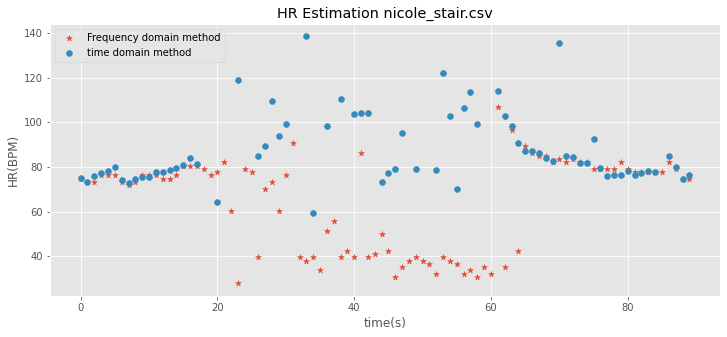

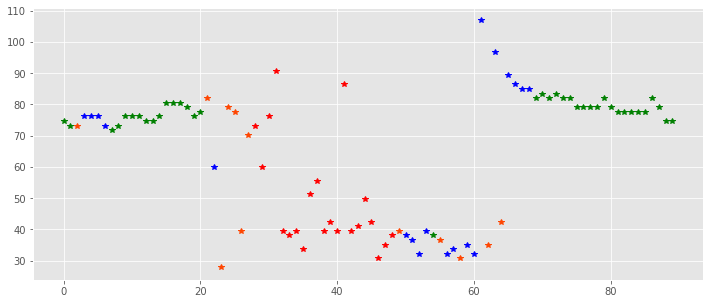

In [312]:
plt.figure(figsize=(12,5))
plt.title("HR Estimation " + fileName)
plt.scatter(np.arange(num_window), HR_est_list, marker="*", label="Frequency domain method")
# plt.scatter(np.arange(num_window), HR_valid_list, marker='^', label="Frequency domain method(linear reg)")
plt.scatter(np.arange(num_window), mean_feat_list['HR'], marker="o", label="time domain method")
# plt.scatter(np.arange(num_window), HR_track_list, marker="*", label="tracking method")
plt.ylabel("HR(BPM)")
plt.xlabel("time(s)")
plt.legend(loc="best")
print(fileName)


plt.figure(figsize=(12,5))
for n in range(num_window):
    if state[n]==4:
        color = 'red'
    elif state[n]==2:
        color = 'blue'
    elif state[n] == 3:
        color = 'orangered'
    else:
        color='green'
    plt.plot(n, HR_est_list[n], color=color, marker='*')
    # plt.plot(n, HR_valid_list[n], color=color, marker='*')
        


In [313]:
print(HR_valid_list[2])

73.2422


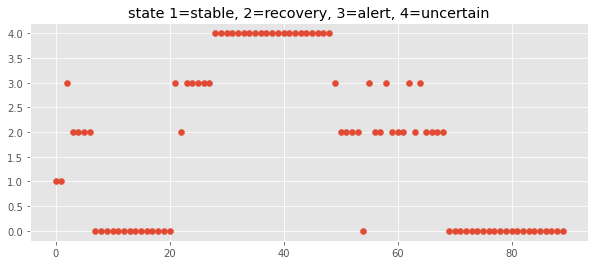

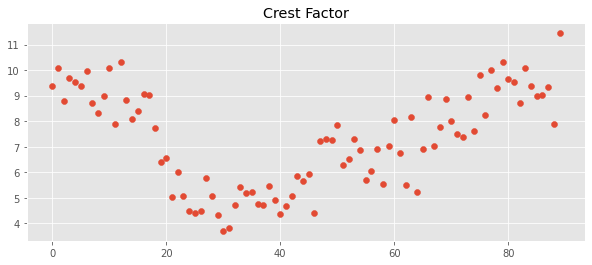

In [314]:
plt.figure(figsize=(10,4))
plt.title("state 1=stable, 2=recovery, 3=alert, 4=uncertain")
plt.scatter(np.arange(num_window), state)
plt.figure(figsize=(10,4))
plt.title("Crest Factor")
plt.scatter(np.arange(num_window), crest_factor)


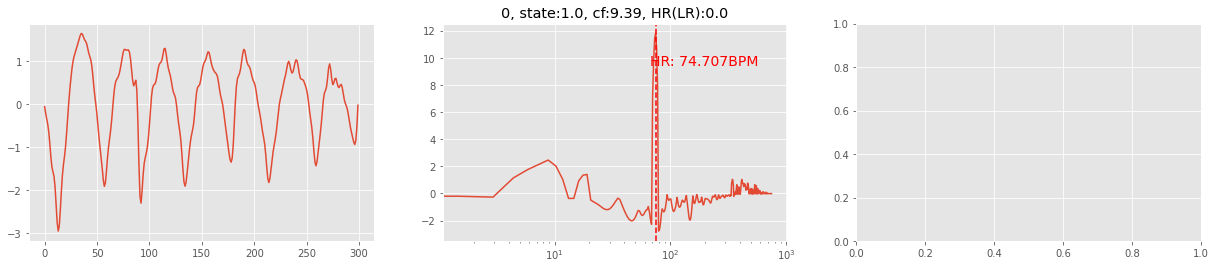

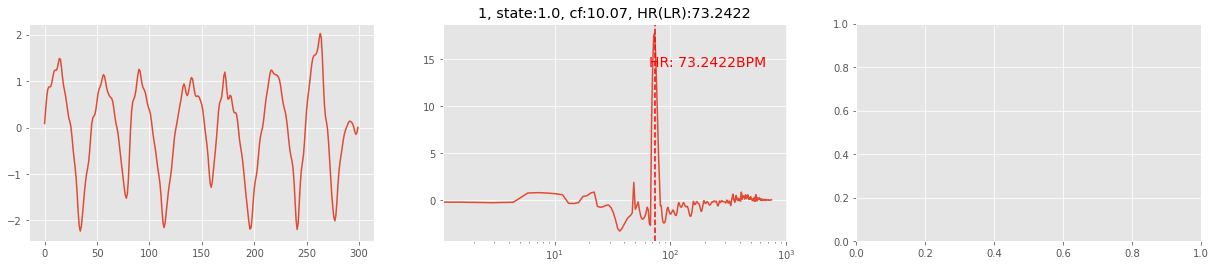

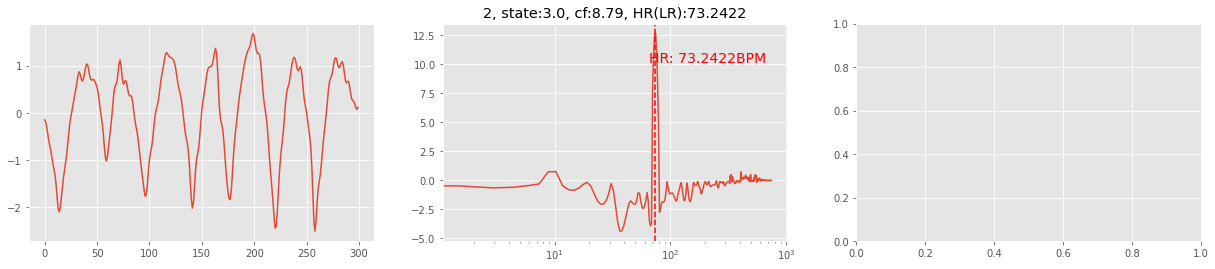

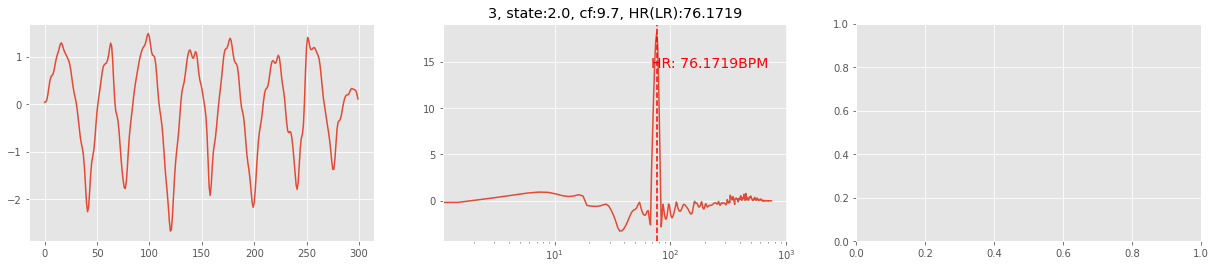

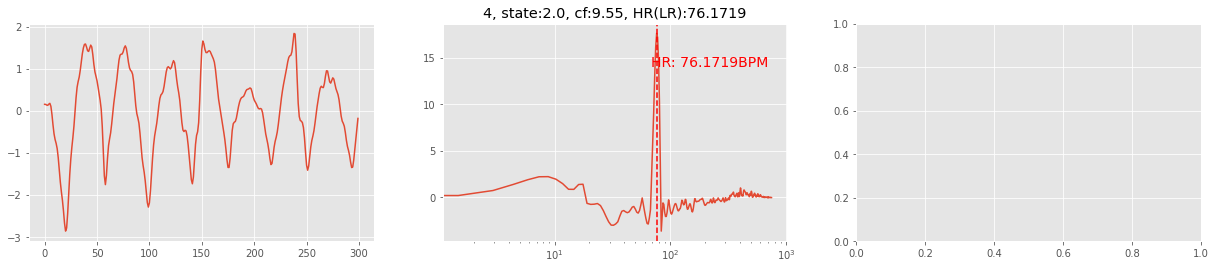

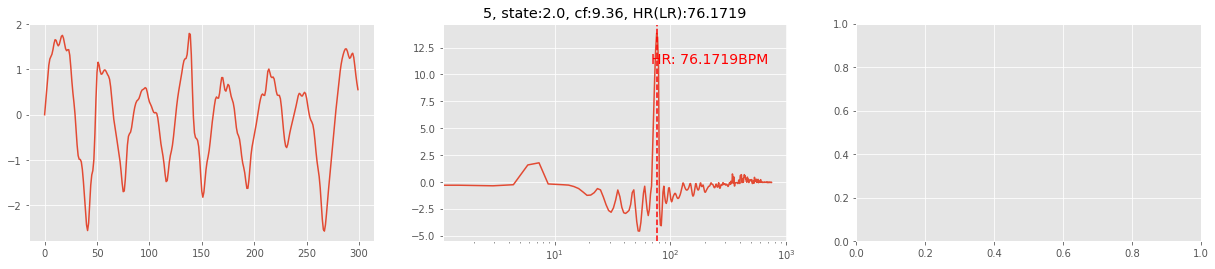

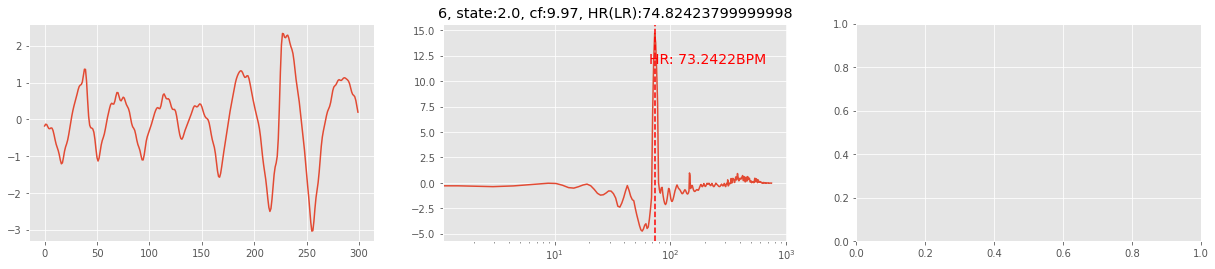

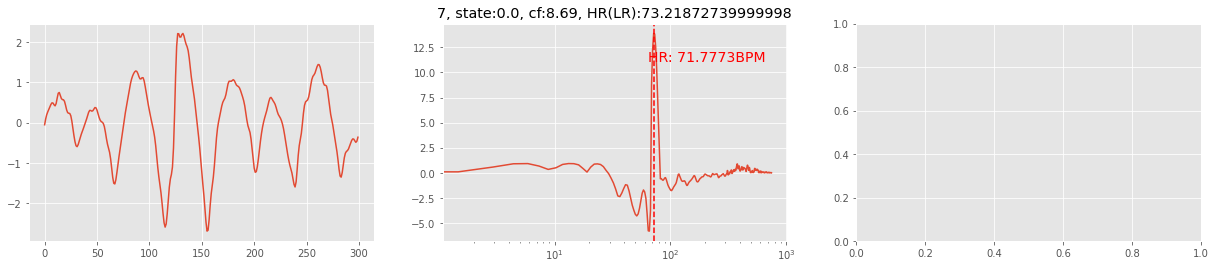

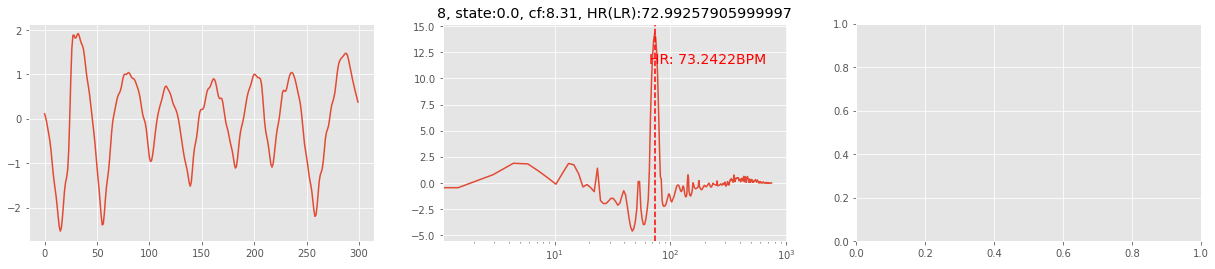

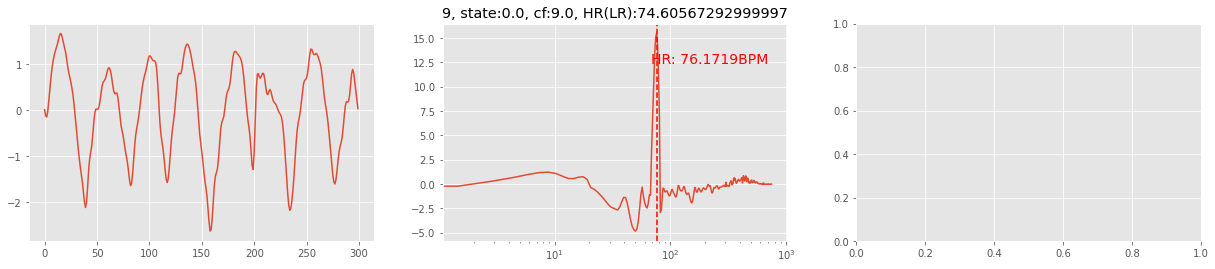

In [315]:
for n in range(0,10):
    fig = plt.figure(figsize = (21 ,4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax1.plot(filtered_PPG[n])
    
    fig_title = str(n) + ', state:' + str(state[n]) + ', cf:' + str(np.round(crest_factor[n],2)) + ', HR(LR):' + str(HR_valid_list[n])
    ax2.set_title(fig_title)
    ax2.semilogx(HR_range, PPG_FFT_FIN[n], label="clean")
    # plt.semilogx(HR_range, PPG_FFT[n], label="observed", ls='--')
    ax2.axvline(HR_est_list[n], color='red', ls='--')
    ax2.text(HR_est_list[n]*0.9, max(PPG_FFT_FIN[n])*0.8 , 'HR: ' + str(HR_est_list[n]) + 'BPM', fontsize=font_size, c='red')


        

In [321]:
freqs[-1]

12.5

In [317]:
len(freqRange)

513

In [318]:
750/513

1.4619883040935673